# Optimizing the Data Processing

`Ascend` `GPU` `CPU` `Data Preparation`

[![](https://gitee.com/mindspore/docs/raw/r1.5/resource/_static/logo_source_en.png)](https://gitee.com/mindspore/docs/blob/r1.5/docs/mindspore/programming_guide/source_en/optimize_data_processing.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/r1.5/resource/_static/logo_notebook_en.png)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r1.5/programming_guide/en/mindspore_optimize_data_processing.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/r1.5/resource/_static/logo_modelarts_en.png)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9taW5kc3BvcmUtd2Vic2l0ZS5vYnMuY24tbm9ydGgtNC5teWh1YXdlaWNsb3VkLmNvbS9ub3RlYm9vay9tYXN0ZXIvcHJvZ3JhbW1pbmdfZ3VpZGUvZW4vbWluZHNwb3JlX29wdGltaXplX2RhdGFfcHJvY2Vzc2luZy5pcHluYg==&imageid=65f636a0-56cf-49df-b941-7d2a07ba8c8c)

## Overview

Data is the most important factor of deep learning. Data quality determines the upper limit of deep learning result, whereas model quality enables the result to approach the upper limit. Therefore, high-quality data input is beneficial to the entire deep neural network. During the entire data processing and data augmentation process, data continuously flows through a pipeline to the training system.

![pipeline](https://gitee.com/mindspore/docs/raw/r1.5/docs/mindspore/programming_guide/source_en/images/pipeline.png)

MindSpore provides data processing and data augmentation functions for users. In the pipeline process, if each step can be properly used, the data performance will be greatly improved. This section describes how to optimize performance during data loading, data processing, and data augmentation based on the CIFAR-10 dataset [1].

In addition, the storage, architecture and computing resources of the operating system will influence the performance of data processing to a certain extent.

## Preparations

### Importing Modules

The `dataset` module provides APIs for loading and processing datasets.

In [1]:
import mindspore.dataset as ds

The `numpy` module is used to generate ndarrays.

In [2]:
import numpy as np

### Downloading the Required Dataset

Run the following command to download the dataset:
Download the CIFAR-10 Binary format dataset, decompress them and store them in the `./datasets` path, use this dataset when loading data.

In [ ]:
!wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz --no-check-certificate
!mkdir -p datasets
!tar -xzf cifar-10-binary.tar.gz -C datasets
!mkdir -p datasets/cifar-10-batches-bin/train datasets/cifar-10-batches-bin/test
!mv -f datasets/cifar-10-batches-bin/test_batch.bin datasets/cifar-10-batches-bin/test
!mv -f datasets/cifar-10-batches-bin/data_batch*.bin datasets/cifar-10-batches-bin/batches.meta.txt datasets/cifar-10-batches-bin/train

The directory structure of the downloaded dataset file is as follows:

```text
./datasets/cifar-10-batches-bin
├── readme.html
├── test
│   └── test_batch.bin
└── train
    ├── batches.meta.txt
    ├── data_batch_1.bin
    ├── data_batch_2.bin
    ├── data_batch_3.bin
    ├── data_batch_4.bin
    └── data_batch_5.bin
```

Download cifar-10 Python file format dataset, decompress them in the `./datasets/cifar-10-batches-py` path, use this dataset when converting data.

In [ ]:
!wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-python.tar.gz --no-check-certificate
!mkdir -p datasets
!tar -xzf cifar-10-python.tar.gz -C datasets

The directory structure of the extracted dataset file is as follows:

```text
./datasets/cifar-10-batches-py
├── batches.meta
├── data_batch_1
├── data_batch_2
├── data_batch_3
├── data_batch_4
├── data_batch_5
├── readme.html
└── test_batch
```

## Optimizing the Data Loading Performance

MindSpore provides multiple data loading methods, including common dataset loading, user-defined dataset loading, and the MindSpore data format loading. The dataset loading performance varies depending on the underlying implementation method.

|      | Common Dataset | User-defined Dataset | MindRecord Dataset |
| :----: | :----: | :----: | :----: |
| Underlying implementation | C++ | Python | C++ |
| Performance | High | Medium | High |

### Performance Optimization Solution

![data-loading-performance-scheme](https://gitee.com/mindspore/docs/raw/r1.5/docs/mindspore/programming_guide/source_en/images/data_loading_performance_scheme.png)

Suggestions on data loading performance optimization are as follows:

- Built-in loading operators are preferred for supported dataset formats. For details, see [Built-in Loading Operators](https://www.mindspore.cn/docs/api/en/r1.5/api_python/mindspore.dataset.html), if the performance cannot meet the requirements, use the multi-thread concurrency solution. For details, see [Multi-thread Optimization Solution](https://www.mindspore.cn/docs/programming_guide/en/r1.5/optimize_data_processing.html#multi-thread-optimization-solution).
- For a dataset format that is not supported, convert the format to the mindspore data format and then use the `MindDataset` class to load the dataset (Please refer to the [API](https://www.mindspore.cn/docs/api/en/r1.5/api_python/dataset/mindspore.dataset.MindDataset.html) for detailed use). Please refer to [Converting Dataset to MindRecord](https://www.mindspore.cn/docs/programming_guide/en/r1.5/convert_dataset.html), if the performance cannot meet the requirements, use the multi-thread concurrency solution, for details, see [Multi-thread Optimization Solution](https://www.mindspore.cn/docs/programming_guide/en/r1.5/optimize_data_processing.html#multi-thread-optimization-solution).
- For dataset formats that are not supported, the user-defined `GeneratorDataset` class is preferred for implementing fast algorithm verification (Please refer to the [API](https://www.mindspore.cn/docs/api/en/r1.5/api_python/dataset/mindspore.dataset.GeneratorDataset.html) for detailed use), if the performance cannot meet the requirements, the multi-process concurrency solution can be used. For details, see [Multi-process Optimization Solution](https://www.mindspore.cn/docs/programming_guide/en/r1.5/optimize_data_processing.html#multi-process-optimization-solution).

### Code Example

Based on the preceding suggestions of data loading performance optimization, the `Cifar10Dataset` class of built-in loading operators (Please refer to the [API](https://www.mindspore.cn/docs/api/en/r1.5/api_python/dataset/mindspore.dataset.Cifar10Dataset.html) for detailed use), the `MindDataset` class after data conversion, and the `GeneratorDataset` class are used to load data. The sample code is displayed as follows:

1. Use the `Cifar10Dataset` class of built-in operators to load the CIFAR-10 dataset in binary format. The multi-thread optimization solution is used for data loading. Four threads are enabled to concurrently complete the task. Finally, a dictionary iterator is created for the data and a data record is read through the iterator.

In [5]:
    cifar10_path = "./datasets/cifar-10-batches-bin/train"

    # create Cifar10Dataset for reading data
    cifar10_dataset = ds.Cifar10Dataset(cifar10_path, num_parallel_workers=4)
    # create a dictionary iterator and read a data record through the iterator
    print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[209, 206, 192],
  [211, 209, 201],
  [221, 217, 213],
  ...
  [172, 175, 194],
  [169, 173, 190],
  [115, 121, 145]],
 [[226, 230, 211],
  [227, 229, 218],
  [230, 232, 221],
  ...
  [153, 153, 171],
  [156, 156, 173],
  [106, 111, 129]],
 [[214, 226, 203],
  [214, 222, 204],
  [217, 227, 206],
  ...
  [167, 166, 176],
  [147, 147, 156],
  [ 78,  84,  96]],
 ...
 [[ 40,  69,  61],
  [ 37,  63,  57],
  [ 43,  68,  66],
  ...
  [ 55,  70,  69],
  [ 40,  54,  51],
  [ 27,  44,  36]],
 [[ 33,  61,  50],
  [ 37,  65,  56],
  [ 54,  72,  74],
  ...
  [ 47,  60,  56],
  [ 58,  66,  64],
  [ 36,  50,  46]],
 [[ 29,  41,  37],
  [ 38,  60,  59],
  [ 51,  76,  81],
  ...
  [ 32,  51,  43],
  [ 47,  61,  54],
  [ 56,  67,  66]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 5)}


2. Use the `Cifar10ToMR` class to convert the CIFAR-10 dataset into the MindSpore data format. In this example, the CIFAR-10 dataset in Python file format is used. Then use the `MindDataset` class to load the dataset in the MindSpore data format. The multi-thread optimization solution is used for data loading. Four threads are enabled to concurrently complete the task. Finally, a dictionary iterator is created for data and a data record is read through the iterator.

In [6]:
import os
from mindspore.mindrecord import Cifar10ToMR

trans_path = "./transform/"

if not os.path.exists(trans_path):
    os.mkdir(trans_path)

os.system("rm -f {}cifar10*".format(trans_path))

cifar10_path = './datasets/cifar-10-batches-py'
cifar10_mindrecord_path = './transform/cifar10.record'

cifar10_transformer = Cifar10ToMR(cifar10_path,cifar10_mindrecord_path)
# execute transformation from CIFAR-10 to MindRecord
cifar10_transformer.transform(['label'])

# create MindDataset for reading data
cifar10_mind_dataset = ds.MindDataset(dataset_file=cifar10_mindrecord_path,num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_mind_dataset.create_dict_iterator()))

{'data': Tensor(shape=[1283], dtype=UInt8, value= [255, 216, 255, 224,   0,  16,  74,  70,  73,  70,   0,   1,   1,   0,   0,   1,   0,   1,   0,   0, 255, 219,   0,  67, 
 107, 249,  17,  58, 213, 185, 117, 181, 143, 255, 217]), 'id': Tensor(shape=[], dtype=Int64, value= 32476), 'label': Tensor(shape=[], dtype=Int64, value= 9)}


3. The `GeneratorDataset` class is used to load the user-defined dataset, and the multi-process optimization solution is used. Four processes are enabled to concurrently complete the task. Finally, a dictionary iterator is created for the data, and a data record is read through the iterator.

In [7]:
    def generator_func(num):
        for i in range(num):
            yield (np.array([i]),)

    # create a GeneratorDataset object for reading data
    dataset = ds.GeneratorDataset(source=generator_func(5), column_names=["data"], num_parallel_workers=4)
    # create a dictionary iterator and read a data record through the iterator
    print(next(dataset.create_dict_iterator()))

{'data': Tensor(shape=[1], dtype=Int64, value= [0])}


## Optimizing the Shuffle Performance

The shuffle operation is used to shuffle ordered datasets or repeated datasets. MindSpore provides the `shuffle` function for users.  A larger value of `buffer_size` indicates a higher shuffling degree, consuming more time and computing resources. This API allows users to shuffle the data at any time during the entire pipeline process.Please refer to [shuffle](https://www.mindspore.cn/docs/programming_guide/en/r1.5/pipeline.html#shuffle). However, because the underlying implementation methods are different, the performance of this method is not as good as that of setting the `shuffle` parameter to directly shuffle data by referring to the [Built-in Loading Operators](https://www.mindspore.cn/docs/api/en/r1.5/api_python/mindspore.dataset.html).

### Performance Optimization Solution

![shuffle-performance-scheme](https://gitee.com/mindspore/docs/raw/r1.5/docs/mindspore/programming_guide/source_en/images/shuffle_performance_scheme.png)

Suggestions on shuffle performance optimization are as follows:

- Use the `shuffle` parameter of built-in loading operators to shuffle data.
- If the `shuffle` function is used and the performance still cannot meet the requirements, adjust the value of the `buffer_size` parameter to improve the performance.

### Code Example

Based on the preceding shuffle performance optimization suggestions, the `shuffle` parameter of the `Cifar10Dataset` class of built-in loading operators and the `Shuffle` function are used to shuffle data. The sample code is displayed as follows:

1. Use the `Cifar10Dataset` class of built-in operators to load the CIFAR-10 dataset. In this example, the CIFAR-10 dataset in binary format is used, and the `shuffle` parameter is set to True to perform data shuffle. Finally, a dictionary iterator is created for the data and a data record is read through the iterator.

In [8]:
    cifar10_path = "./datasets/cifar-10-batches-bin/train"

    # create Cifar10Dataset for reading data
    cifar10_dataset = ds.Cifar10Dataset(cifar10_path, shuffle=True)
    # create a dictionary iterator and read a data record through the iterator
    print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[119, 193, 196],
  [121, 192, 204],
  [123, 193, 209],
  ...
  [110, 168, 177],
  [109, 167, 176],
  [110, 168, 178]],
 [[110, 188, 199],
  [109, 185, 202],
  [111, 186, 204],
  ...
  [107, 173, 179],
  [107, 173, 179],
  [109, 175, 182]],
 [[110, 186, 200],
  [108, 183, 199],
  [110, 184, 199],
  ...
  [115, 183, 189],
  [117, 185, 190],
  [117, 185, 191]],
 ...
 [[210, 253, 250],
  [212, 251, 250],
  [214, 250, 249],
  ...
  [194, 247, 247],
  [190, 246, 245],
  [184, 245, 244]],
 [[215, 253, 251],
  [218, 252, 250],
  [220, 251, 249],
  ...
  [200, 248, 248],
  [195, 247, 245],
  [189, 245, 244]],
 [[216, 253, 253],
  [222, 251, 250],
  [225, 250, 249],
  ...
  [204, 249, 248],
  [200, 246, 244],
  [196, 245, 244]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 0)}


2. Use the `shuffle` function to shuffle data. Set `buffer_size` to 3 and use the `GeneratorDataset` class to generate data.

In [9]:
    def generator_func():
        for i in range(5):
            yield (np.array([i, i+1, i+2, i+3, i+4]),)

    ds1 = ds.GeneratorDataset(source=generator_func, column_names=["data"])
    print("before shuffle:")
    for data in ds1.create_dict_iterator():
        print(data["data"])

    ds2 = ds1.shuffle(buffer_size=3)
    print("after shuffle:")
    for data in ds2.create_dict_iterator():
        print(data["data"])

before shuffle:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after shuffle:
[2 3 4 5 6]
[0 1 2 3 4]
[1 2 3 4 5]
[4 5 6 7 8]
[3 4 5 6 7]


## Optimizing the Data Augmentation Performance

During image classification training, especially when the dataset is small, users can use data augmentation to preprocess images to enrich the dataset. MindSpore provides multiple data augmentation methods, including:

- Use the built-in C operator (`c_transforms` module) to perform data augmentation.
- Use the built-in Python operator (`py_transforms` module) to perform data augmentation.
- Users can define Python functions as needed to perform data augmentation.

Please refer to [Data Augmentation](https://www.mindspore.cn/docs/programming_guide/en/r1.5/augmentation.html). The performance varies according to the underlying implementation methods.

| Module | Underlying API | Description |
| :----: | :----: | :----: |
| c_transforms | C++ (based on OpenCV) | High performance |
| py_transforms | Python (based on PIL) | This module provides multiple image augmentation functions and the method for converting PIL images into NumPy arrays |

### Performance Optimization Solution

![data-enhancement-performance-scheme](https://gitee.com/mindspore/docs/raw/r1.5/docs/mindspore/programming_guide/source_en/images/data_enhancement_performance_scheme.png)

Suggestions on data augmentation performance optimization are as follows:

- The `c_transforms` module is preferentially used to perform data augmentation for its highest performance. If the performance cannot meet the requirements, refer to [Multi-thread Optimization Solution](https://www.mindspore.cn/docs/programming_guide/en/r1.5/optimize_data_processing.html#multi-thread-optimization-solution), [Compose Optimization Solution](https://www.mindspore.cn/docs/programming_guide/en/r1.5/optimize_data_processing.html#compose-optimization-solution), or [Operator Fusion Optimization Solution](https://www.mindspore.cn/docs/programming_guide/en/r1.5/optimize_data_processing.html#operator-fusion-optimization-solution).
- If the `py_transforms` module is used to perform data augmentation and the performance still cannot meet the requirements, refer to [Multi-thread Optimization Solution](https://www.mindspore.cn/docs/programming_guide/en/r1.5/optimize_data_processing.html#multi-thread-optimization-solution), [Multi-process Optimization Solution](https://www.mindspore.cn/docs/programming_guide/en/r1.5/optimize_data_processing.html#multi-process-optimization-solution), [Compose Optimization Solution](https://www.mindspore.cn/docs/programming_guide/en/r1.5/optimize_data_processing.html#compose-optimization-solution), or [Operator Fusion Optimization Solution](https://www.mindspore.cn/docs/programming_guide/en/r1.5/optimize_data_processing.html#operator-fusion-optimization-solution).
- The `c_transforms` module maintains buffer management in C++, and the `py_transforms` module maintains buffer management in Python. Because of the performance cost of switching between Python and C++, it is advised not to use different operator types together.
- If the user-defined Python functions are used to perform data augmentation and the performance still cannot meet the requirements, use the [Multi-thread Optimization Solution](https://www.mindspore.cn/docs/programming_guide/en/r1.5/optimize_data_processing.html#multi-thread-optimization-solution) or [Multi-process Optimization Solution](https://www.mindspore.cn/docs/programming_guide/en/r1.5/optimize_data_processing.html#multi-process-optimization-solution). If the performance still cannot be improved, in this case, optimize the user-defined Python code.

MindSpore also supports users to use the data enhancement methods in the `c_transforms` and `py_transforms` modules at the same time, but due to the different underlying implementations of the two, excessive mixing will increase resource overhead and reduce processing performance. It is recommended that users can use the operators in `c_transforms` or `py_transforms` alone; or use one of them first, and then use the other. Please do not switch frequently between the data enhancement interface of two different implementation modules.

### Code Example

Based on the preceding suggestions of data augmentation performance optimization, the `c_transforms` module and user-defined Python function are used to perform data augmentation. The code is displayed as follows:

1. The `c_transforms` module is used to perform data augmentation. During data augmentation, the multi-thread optimization solution is used. Four threads are enabled to concurrently complete the task. The operator fusion optimization solution is used and the `RandomResizedCrop` fusion class is used to replace the `RandomResize` and `RandomCrop` classes.

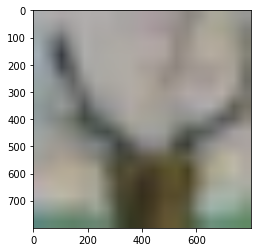

In [10]:
    import mindspore.dataset.transforms.c_transforms as c_transforms
    import mindspore.dataset.vision.c_transforms as C
    import matplotlib.pyplot as plt

    cifar10_path = "./datasets/cifar-10-batches-bin/train"

    # create Cifar10Dataset for reading data
    cifar10_dataset = ds.Cifar10Dataset(cifar10_path, num_parallel_workers=4)
    transforms = C.RandomResizedCrop((800, 800))
    # apply the transform to the dataset through dataset.map()
    cifar10_dataset = cifar10_dataset.map(operations=transforms, input_columns="image", num_parallel_workers=4)

    data = next(cifar10_dataset.create_dict_iterator())
    plt.imshow(data["image"].asnumpy())
    plt.show()

2. A user-defined Python function is used to perform data augmentation. During data augmentation, the multi-process optimization solution is used, and four processes are enabled to concurrently complete the task.

In [11]:
    def generator_func():
        for i in range(5):
            yield (np.array([i, i+1, i+2, i+3, i+4]),)

    ds3 = ds.GeneratorDataset(source=generator_func, column_names=["data"])
    print("before map:")
    for data in ds3.create_dict_iterator():
        print(data["data"])

    func = lambda x:x**2
    ds4 = ds3.map(operations=func, input_columns="data", python_multiprocessing=True, num_parallel_workers=4)
    print("after map:")
    for data in ds4.create_dict_iterator():
        print(data["data"])

before map:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after map:
[ 0  1  4  9 16]
[ 1  4  9 16 25]
[ 4  9 16 25 36]
[ 9 16 25 36 49]
[16 25 36 49 64]


## Optimizing the Operating System Performance

Data processing is performed on the host. Therefore, configurations of the host or operating system may affect the performance of data processing.  Major factors include storage, NUMA architecture, and CPU (computing resources).

1. Storage

    The data loading process involves frequent disk operations, and the performance of disk reading and writing directly affects the speed of data loading. Solid State Drive (SSD) is recommended for storing large datasets. SSD reduces the impact of I/O on data processing.

    > In most cases, after a dataset is loaded, it is stored in page cache of the operating system. To some extent, this reduces I/O overheads and accelerates reading subsequent epochs.

2. NUMA architecture

    NUMA (Non-uniform Memory Architecture) is developed to solve the scalability problem of traditional Symmetric Multi-processor systems. The NUMA system has multiple memory buses. Several processors are connected to one memory via memory bus to form a group. This way, the entire large system is divided into several groups, the concept of this group is called a node in the NUMA system. Memory belonging to this node is called local memory, memory belonging to other nodes (with respect to this node) is called foreign memory. Therefore, the latency for each node to access its local memory is different from accessing foreign memory. This needs to be avoided during data processing. Generally, the following command can be used to bind a process to a node:

    ```bash
    numactl --cpubind=0 --membind=0 python train.py
    ```

    The example above binds the `train.py` process to `numa node` 0.

3. CPU (computing resource)

    Although the data processing speed can be accelerated through multi-threaded parallel technology, there is actually no guarantee that CPU computing resources will be fully utilized. If you can artificially complete the configuration of computing resources in advance, it will be able to improve the utilization of CPU computing resources to a certain extent.

    - Resource allocation

        In distributed training, multiple training processes are run on one device. These training processes allocate and compete for computing resources based on the policy of the operating system. When there is a large number of processes, data processing performance may deteriorate due to resource contention. In some cases, users need to manually allocate resources to avoid resource contention.
        
        ```bash
        numactl --cpubind=0 python train.py
        ```
        
        or
        
        ```bash
        taskset -c 0-15 python train.py
        ```
        
        > The `numactl` method directly specifies `numa node id`. The `taskset` method allows for finer control by specifying `cpu core` within a `numa node`. The `core id` range from 0 to 15.
        
    - CPU frequency

        The setting of CPU frequency is critical to maximizing the computing power of the host CPU. Generally, the Linux kernel supports the tuning of the CPU frequency to reduce power consumption. Power consumption can be reduced to varying degrees by selecting power management policies for different system idle states. However, lower power consumption means slower CPU wake-up which in turn impacts performance. Therefore, if the CPU's power setting is in the conservative or powersave mode, `cpupower` command can be used to switch performance modes, resulting in significant data processing performance improvement.
    
        ```bash
        cpupower frequency-set -g performance
        ```

## Performance Optimization Solution Summary

### Multi-thread Optimization Solution

During the data pipeline process, the number of threads for related operators can be set to improve the concurrency and performance. If the user does not manually specify the `num_parallel_workers` parameter, each data processing operation will use 8 sub-threads for concurrent processing by default. For example:

- During data loading, the `num_parallel_workers` parameter in the built-in data loading class is used to set the number of threads.
- During data augmentation, the `num_parallel_workers` parameter in the `map` function is used to set the number of threads.
- During batch processing, the `num_parallel_workers` parameter in the `batch` function is used to set the number of threads.

For details, see [Built-in Loading Operators](https://www.mindspore.cn/docs/api/en/r1.5/api_python/mindspore.dataset.html).

When using MindSpore for standalone or distributed training, the setting of the `num_parallel_workers` parameter should follow the following principles:

- The summary of the `num_parallel_workers` parameter set for each data loading and processing operation should not be greater than the maximum number of CPU cores of the machine, otherwise it will cause resource competition between each operation.
- Before setting the `num_parallel_workers` parameter, it is recommended to use MindSpore's Profiler (performance analysis) tool to analyze the performance of each operation in the training, and allocate more resources to the operation with pool performance, that is, set a large `num_parallel_workers` to balance the throughput between various operations and avoid unnecessary waiting.
- In a standalone training scenario, increasing the `num_parallel_workers` parameter can often directly improve processing performance, but in a distributed scenario, due to increased CPU competition, blindly increasing `num_parallel_workers` may lead to performance degradation. You need to try to use a compromise value.

### Multi-process Optimization Solution

During data processing, operators implemented by Python support the multi-process mode. For example:

- By default, the `GeneratorDataset` class is in multi-process mode. The `num_parallel_workers` parameter indicates the number of enabled processes. The default value is 1. For details, see [GeneratorDataset](https://www.mindspore.cn/docs/api/en/r1.5/api_python/dataset/mindspore.dataset.GeneratorDataset.html).
- If the user-defined Python function or the `py_transforms` module is used to perform data augmentation and the `python_multiprocessing` parameter of the `map` function is set to True, the `num_parallel_workers` parameter indicates the number of processes and the default value of the `python_multiprocessing` parameter is False. In this case, the `num_parallel_workers` parameter indicates the number of threads. For details, see [Built-in Loading Operators](https://www.mindspore.cn/docs/api/en/r1.5/api_python/mindspore.dataset.html).

### Compose Optimization Solution

Map operators can receive the Tensor operator list and apply all these operators based on a specific sequence. Compared with the Map operator used by each Tensor operator, such Fat Map operators can achieve better performance, as shown in the following figure:

![compose](https://gitee.com/mindspore/docs/raw/r1.5/docs/mindspore/programming_guide/source_en/images/compose.png)

### Operator Fusion Optimization Solution

Some fusion operators are provided to aggregate the functions of two or more operators into one operator. For details, see [Augmentation Operators](https://www.mindspore.cn/docs/api/en/r1.5/api_python/mindspore.dataset.vision.html). Compared with the pipelines of their components, such fusion operators provide better performance. As shown in the figure:

![operator-fusion](https://gitee.com/mindspore/docs/raw/r1.5/docs/mindspore/programming_guide/source_en/images/operator_fusion.png)

### Operating System Optimization Solution

- Use Solid State Drives to store the data.
- Bind the process to a NUMA node.
- Manually allocate more computing resources.
- Set a higher CPU frequency.

## References

[1] Alex Krizhevsky. [Learning Multiple Layers of Features from Tiny Images](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf).